# End-to-End California Housing Price Prediction

We're going to take this following approach for this particular machine learning project
1. Problem statement.
2. Performance measure.
3. Get the data.
4. Discover and visualize the data to gain insights.
5. Prepare the data for Machine Learning algorithms.
6. Select a model and train it.
7. Fine-tune your model.
8. Present your solution.
9. Launch, monitor, and maintain your system.

## Problem statement

We've to predict median house prices of districts based on the data which will be fed to another Machine Learning system along with many other signals.This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.


## Performance measure

This problem is a multivariate regression problem. So, RMSE(Root Mean Squared Error) is a good performance measure for most of the regression problem. . It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

## Get The Data

The data is collected from https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [2]:
housing_df = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")

## Dicovering and Visualizing The Data 

In [3]:
housing_df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_df.shape

(20640, 10)

In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

We can see that there are 207 missing values in total bedroom. We'll take care of that later

In [7]:
housing_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


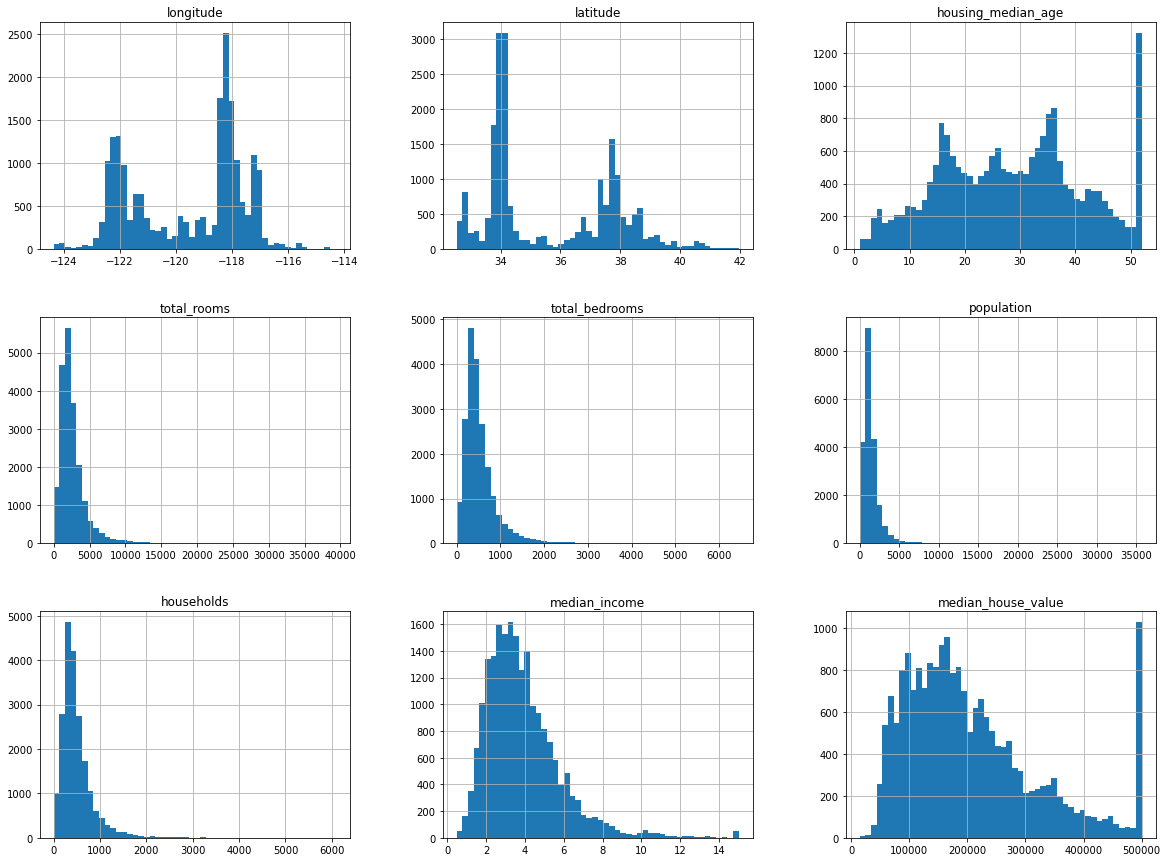

In [9]:
%matplotlib inline
housing_df.hist(bins=50,figsize=(20,15))
plt.show()

The following code uses the pd.cut() function to create an income category attribute with 5 categories (labeled
from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from
1.5 to 3, and so on:

In [10]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],bins=[0.,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])

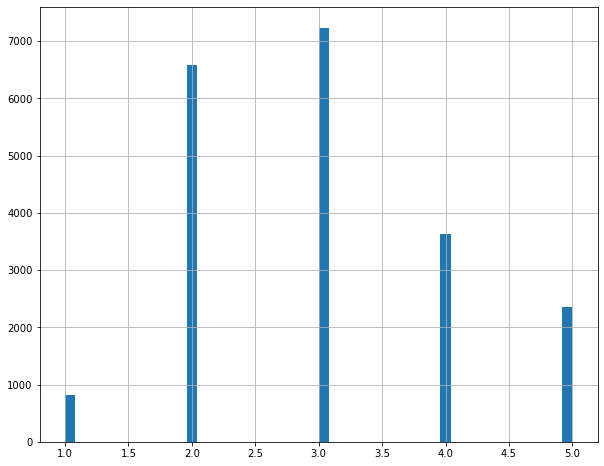

In [11]:
housing_df.income_cat.hist(bins=50,figsize=(10,8));

Now we're ready to do stratifiedshufflesplit based on the income_cat column

In [12]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing_df,housing_df.income_cat):
    strat_train_set = housing_df.iloc[train_index]
    strat_test_set = housing_df.iloc[test_index]

In [13]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original
state:

In [14]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

C:\Users\Souritra\AppData\Local\Temp\ipykernel_22556\2188684755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat",axis=1,inplace=True)
C:\Users\Souritra\AppData\Local\Temp\ipykernel_22556\2188684755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat",axis=1,inplace=True)


In [15]:
housing = strat_test_set.copy()

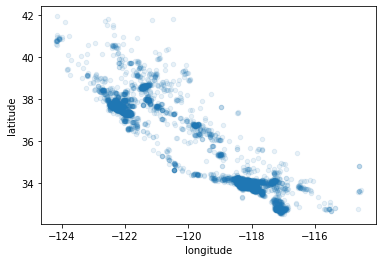

In [16]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1);

Now let’s look at the housing prices. The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices)

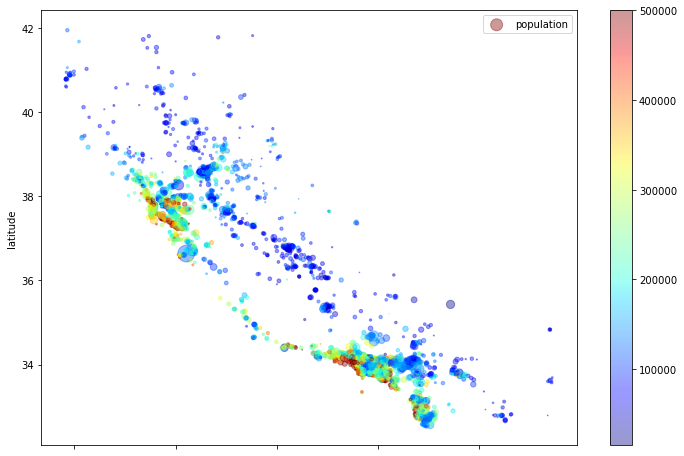

In [17]:
housing.plot(figsize=(12,8),kind="scatter",x="longitude",y="latitude",alpha=0.4,s=housing["population"]/100,label="population",c=housing["median_house_value"],cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already

### Looking for correlations

In [18]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925426,-0.117560,0.028628,0.043930,0.068887,0.026334,0.002910,-0.039848
latitude,-0.925426,1.000000,0.032850,-0.024331,-0.046573,-0.084358,-0.045920,-0.099023,-0.150336
housing_median_age,-0.117560,0.032850,1.000000,-0.350487,-0.304722,-0.287470,-0.290560,-0.150288,0.071210
total_rooms,0.028628,-0.024331,-0.350487,1.000000,0.933630,0.864091,0.918768,0.191623,0.131296
total_bedrooms,0.043930,-0.046573,-0.304722,0.933630,1.000000,0.882700,0.978303,-0.000252,0.057247
population,0.068887,-0.084358,-0.287470,0.864091,0.882700,1.000000,0.916104,0.014239,-0.016164
households,0.026334,-0.045920,-0.290560,0.918768,0.978303,0.916104,1.000000,0.021517,0.070947
median_income,0.002910,-0.099023,-0.150288,0.191623,-0.000252,0.014239,0.021517,1.000000,0.691867
median_house_value,-0.039848,-0.150336,0.071210,0.131296,0.057247,-0.016164,0.070947,0.691867,1.000000


In [19]:
# Let's see how much each value correlates to median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691867
total_rooms           0.131296
housing_median_age    0.071210
households            0.070947
total_bedrooms        0.057247
population           -0.016164
longitude            -0.039848
latitude             -0.150336
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

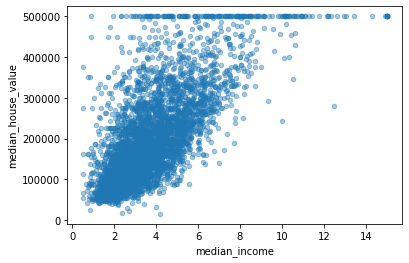

In [20]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.4)

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691867
rooms_per_household         0.192731
total_rooms                 0.131296
housing_median_age          0.071210
households                  0.070947
total_bedrooms              0.057247
population                 -0.016164
longitude                  -0.039848
population_per_household   -0.134999
latitude                   -0.150336
bedrooms_per_room          -0.240481
Name: median_house_value, dtype: float64

In [23]:
housing = strat_train_set.copy()

In [24]:
housing_features = housing.drop("median_house_value",axis=1)
housing_label = housing["median_house_value"]

In [25]:
imputer = SimpleImputer(strategy="median")

In [26]:
housing_num = housing_features.drop("ocean_proximity", axis=1)

In [27]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [29]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [30]:
X = imputer.transform(housing_num)

In [31]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [32]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [33]:
housing_cat = housing[["ocean_proximity"]]

In [34]:
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [35]:
ordinal_encoder = OrdinalEncoder()

In [36]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [37]:
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
housing_cat.ocean_proximity.astype("category")

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
            ...    
15174     <1H OCEAN
12661        INLAND
19263     <1H OCEAN
19140     <1H OCEAN
19773        INLAND
Name: ocean_proximity, Length: 16512, dtype: category
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [40]:
housing_cat_encoded = pd.get_dummies(housing_cat["ocean_proximity"])

In [41]:
housing_cat_encoded

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0
...,...,...,...,...,...
15174,1,0,0,0,0
12661,0,1,0,0,0
19263,1,0,0,0,0
19140,1,0,0,0,0


In [42]:
cat_encoder = OneHotEncoder()

In [43]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [44]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
 def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
     self.add_bedrooms_per_room = add_bedrooms_per_room
 def fit(self, X, y=None):
     return self # nothing else to do
 def transform(self, X, y=None):
     rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
     population_per_household = X[:, population_ix] / X[:, households_ix]
     if self.add_bedrooms_per_room:
         bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
         return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
     else:
         return np.c_[X, rooms_per_household, population_per_household]


In [46]:
num_pipeline = Pipeline([
                        ("imputer",SimpleImputer(strategy="median")),
                        ("addatrib",CombinedAttributesAdder()),
                        ("std",StandardScaler()),
                         ])

In [47]:
housing_tr = num_pipeline.fit_transform(housing_num)

In [48]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                    ("num",num_pipeline,num_attribs),
                                    ("cat",cat_encoder,cat_attribs)
                                    ])

In [49]:
housing_prepared = full_pipeline.fit_transform(housing_features)

In [50]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

## Select And Train A Model

In [51]:
regr = LinearRegression()
regr.fit(housing_prepared,housing_label)

LinearRegression()

In [52]:
# Evaluating model on training data
housing_predictions = regr.predict(housing_prepared)
np.sqrt(mean_squared_error(housing_label,housing_predictions))

68627.87390018745

Let's try on a KNeighBorsModel

In [53]:
regr = KNeighborsRegressor()
regr.fit(housing_prepared,housing_label)

KNeighborsRegressor()

In [54]:
housing_predictions = regr.predict(housing_prepared)
np.sqrt(mean_squared_error(housing_label,housing_predictions))

49832.19186662649

In [55]:
# Let's create a function to train our model on different ensemble methods and evaluate them using cross_validation

def model_train(X,y):
    ensemble_models = [RandomForestRegressor(), AdaBoostRegressor(), HistGradientBoostingRegressor(),GradientBoostingRegressor(), ExtraTreesRegressor()]
    for model in ensemble_models:
        scores = cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5)
        print(f"{model} : {np.mean(np.sqrt(-scores))}")

In [56]:
model_train(housing_prepared,housing_label)

RandomForestRegressor() : 50607.25217513552
AdaBoostRegressor() : 81518.91869318605
HistGradientBoostingRegressor() : 46795.91200274277
GradientBoostingRegressor() : 53383.61127746741
ExtraTreesRegressor() : 50764.63640727673


Apparently HistGradientBoostingregressor performs better than all the other models, so we will use this model

In [57]:
hist_model = HistGradientBoostingRegressor()
hist_model.fit(housing_prepared,housing_label)

HistGradientBoostingRegressor()

In [58]:
hist_model.score(housing_prepared,housing_label)

0.8818011050552789

In [59]:
import joblib
joblib.dump(hist_model,"my_model.pkl")

['my_model.pkl']

In [60]:
loaded_model = joblib.load("my_model.pkl")

## Fine Tuning Our Model

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
param_grid = [{"learning_rate":[0.1,0.2,0.3,0.4],"min_samples_leaf":[2,4,6,8],"max_depth":[1,2,3,5]}]

In [63]:
hist_model = HistGradientBoostingRegressor()

In [64]:
gs_model = GridSearchCV(hist_model,param_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True)

In [65]:
gs_model.fit(housing_prepared,housing_label)

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3, 0.4],
                          'max_depth': [1, 2, 3, 5],
                          'min_samples_leaf': [2, 4, 6, 8]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [67]:
score = gs_model.best_score_
print(np.sqrt(-score))

47551.79211403673


In [68]:
gs_model.best_estimator_

HistGradientBoostingRegressor(learning_rate=0.2, max_depth=5,
                              min_samples_leaf=4)

In [70]:
cv_scores = cross_val_score(gs_model,housing_prepared,housing_label,cv=5)
print(np.mean(np.sqrt(-cv_scores)))

47465.25685816885


Our previous model was performing slightly better than this GridSearchModel, so we'll use that one.

In [84]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [85]:
X_test_prepared = full_pipeline.transform(X_test)

In [86]:
final_predictions = loaded_model.predict(X_test_prepared)

In [88]:
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

68025.22977733196

seems like our model doesn't generalize well with the unseen data, let's try one last model

In [90]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(housing_prepared,housing_label)
random_forest_model.score(X_test_prepared,y_test)

0.5332322795199479

In [92]:
final_predictions = random_forest_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

77996.49854731566

Our loaded model was performing better than the RandomizedTrees model. So, that is our final model, and it is ready for production